# Dependency Imports & Accessing the Database

In [74]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder

In [75]:
db_path = "data/gas_monitoring.db"
connect_db = sqlite3.connect(db_path)
df = pd.read_sql("SELECT * FROM gas_monitoring", connect_db)

# Quick Dataset Checks

In [76]:
# Basic Info of the Database
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time of Day                10000 non-null  object 
 1   Temperature                10000 non-null  float64
 2   Humidity                   10000 non-null  float64
 3   CO2_InfraredSensor         10000 non-null  float64
 4   CO2_ElectroChemicalSensor  9294 non-null   float64
 5   MetalOxideSensor_Unit1     10000 non-null  float64
 6   MetalOxideSensor_Unit2     10000 non-null  float64
 7   MetalOxideSensor_Unit3     7434 non-null   float64
 8   MetalOxideSensor_Unit4     10000 non-null  float64
 9   CO_GasSensor               8631 non-null   object 
 10  Session ID                 10000 non-null  int64  
 11  HVAC Operation Mode        10000 non-null  object 
 12  Ambient Light Level        7468 non-null   object 
 13  Activity Level             10000 non-null  obje

In [77]:
# Any missing values?
missing = df.isna().sum()
missing
# We'll handle missing values later because I want to handle
# duplicate rows with exact same feature values first

Time of Day                     0
Temperature                     0
Humidity                        0
CO2_InfraredSensor              0
CO2_ElectroChemicalSensor     706
MetalOxideSensor_Unit1          0
MetalOxideSensor_Unit2          0
MetalOxideSensor_Unit3       2566
MetalOxideSensor_Unit4          0
CO_GasSensor                 1369
Session ID                      0
HVAC Operation Mode             0
Ambient Light Level          2532
Activity Level                  0
dtype: int64

In [99]:
# Any duplicate rows?
dups = df.duplicated(keep=False).any()
print(dups)

False


In [130]:
# How many total exact full-row duplicates?
any_dups = df.duplicated(keep=False).any()
# How many full-row duplicates except for the first instance?
dups_except_first_dup_row = df.duplicated(keep='first').sum()

print("Any exact full-row duplicates?", any_dups)
print("Rows that are dups except the first original one:", dups_except_first_dup_row)

Any exact full-row duplicates? False
Rows that are dups except the first original one: 0


In [131]:
# Create a dataframe to show every full-row duplicate and their indices
from collections import defaultdict

index_map = defaultdict(list)
for idx, row in df[df.duplicated(keep=False)].iterrows():
    key = tuple(row.values)
    index_map[key].append(idx)

rows = []
for key, indices in sorted(index_map.items(), key=lambda x: len(x[1]), reverse=True):
    if len(indices) > 1:
        rows.append({'dup_count': len(indices), 'indices': indices, 'example_row': key})

dup_summary_filtered = pd.DataFrame(rows)
dup_summary_filtered.head(300)

""


In [102]:
if not dup_summary_filtered.empty:
    top = dup_summary_filtered.iloc[0]
    mask = df.apply(lambda r: tuple(r.values) == top['example_row'], axis=1)
    df[mask].reset_index(inplace=True)
else:
    print("No exact duplicate groups with >1 member found")

No exact duplicate groups with >1 member found


In [103]:
df[mask].head(20)

C:\Users\longs\AppData\Local\Temp\ipykernel_23272\1721613564.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[mask].head(20)


,Time of Day,Temperature,Humidity,CO2_InfraredSensor,CO2_ElectroChemicalSensor,MetalOxideSensor_Unit1,MetalOxideSensor_Unit2,MetalOxideSensor_Unit3,MetalOxideSensor_Unit4,CO_GasSensor,Session ID,HVAC Operation Mode,Ambient Light Level,Activity Level,Activity_Level_Encoded
579,afternoon,18.40,52.92,105.40,593.77,502.01,752.28,711.66,651.27,low,9658,Ventilation,very_bright,Low Activity,1
587,afternoon,19.49,50.06,89.64,606.54,498.08,752.76,717.87,655.07,extremely low,9127,Maintenance,dim,Moderate Activity,2
2330,night,20.97,52.77,125.80,565.20,371.84,684.74,641.12,551.72,high,7395,Ventilation,dim,Low Activity,1


In [104]:
indices = [1972, 4928, 5888]
df.loc[indices]
# Double checking dup rows, we can see full duplication of row even the Session ID
# which means the duplicates will may high likely ingestion-error duplicates
# safe to say that we can remove these duplicates

,Time of Day,Temperature,Humidity,CO2_InfraredSensor,CO2_ElectroChemicalSensor,MetalOxideSensor_Unit1,MetalOxideSensor_Unit2,MetalOxideSensor_Unit3,MetalOxideSensor_Unit4,CO_GasSensor,Session ID,HVAC Operation Mode,Ambient Light Level,Activity Level,Activity_Level_Encoded
1972,morning,17.25,50.73,81.76,607.41,543.93,773.12,728.61,684.80,low,4129,Eco,moderate,Moderate Activity,2
4928,evening,297.51,47.06,111.72,571.60,454.94,729.64,675.84,615.65,low,4507,Off,None,Moderate Activity,2
5888,night,19.61,56.25,138.37,564.50,402.09,716.75,NaN,593.60,medium,8649,Maintenance,moderate,Moderate Activity,2


In [105]:
# Recompute canonical stats
total_dup_members = df.duplicated(keep=False).sum()            # every row that sits in a duplicate group
rows_removed_if_keep_first = df.duplicated(keep='first').sum()# what drop_duplicates would remove
# Build group sizes by grouping identical full rows
dup_group_sizes = df[df.duplicated(keep=False)].groupby(list(df.columns), dropna=False).size().reset_index(name='dup_count')
num_dup_groups = dup_group_sizes.shape[0]                      # number of distinct duplicated-row values (groups)
sum_dup_counts = dup_group_sizes['dup_count'].sum()            # should equal total_dup_members
derived_removed = (dup_group_sizes['dup_count'] - 1).sum()     # sum of (dup_count - 1) across groups

print("Total rows that are members of duplicated groups (keep=False):", total_dup_members)
print("Rows removed by drop_duplicates(keep='first'):", rows_removed_if_keep_first)
print("Number of distinct duplicate groups (dup_count > 0):", num_dup_groups)
print("Sum of dup_count across groups (should equal total_dup_members):", sum_dup_counts)
print("Derived rows removed (sum of dup_count - 1):", derived_removed)

# Optional: quick sanity asserts
assert sum_dup_counts == total_dup_members
assert derived_removed == rows_removed_if_keep_first

# Quick math check to show the correct amount of rows that will be removed = 120

Total rows that are members of duplicated groups (keep=False): 0
Rows removed by drop_duplicates(keep='first'): 0
Number of distinct duplicate groups (dup_count > 0): 0
Sum of dup_count across groups (should equal total_dup_members): 0
Derived rows removed (sum of dup_count - 1): 0


| **Why Removing Duplicates is Generally Good** |
|------|
**Prevents Bias:** Duplicate rows may overrepresent certain classes or data points, skewing the model's perception of the true data distribution|
**Reduces Overfitting:** If the same data points appear multiple times in the training data, the model may memorize those specific examples rather than learning general patterns, making it less effective on new, unseen data|
**Improves Generalization:** A model trained on a clean, de-duplicated dataset is more likely to generalize well to real-world data|
**Accurate Evaluation:** Duplicates appearing in both training and test sets can lead to artificially high accuracy metrics, giving a false sense of the model's performance


In [106]:
# Dropping duplicates here on EDA because it is a crucial for the EDA checks
df_deduped = df.drop_duplicates(keep='first').reset_index(drop=True)

# Confirm how many rows were removed
removed_count = len(df) - len(df_deduped)
print(f"Exact duplicates removed: {removed_count}")

df = df_deduped
df.duplicated(keep=False).any()

Exact duplicates removed: 0


False

# Why normalize labels
Normalizing labels makes your EDA, preprocessing, and model results reliable and reproducible by removing accidental variation that would otherwise be treated as distinct categories

In [107]:
# Audit original label
print("Before:", df["Activity Level"].value_counts(dropna=False))

# Canonicalize
def canonicalize(s):
    if pd.isna(s):
        return "" # if s is missing returns empty string
    s = str(s)    # Converts input to string, ensures no other non-string types
    s = s.strip() # Removes leading and trailing whitespace
    s = s.replace("_", " ") # replace underscores for spaces
    s = re.sub(r"\s+", " ", s)   # collapse whitespace into a single space
    s = s.lower() # Converts string to lowercase
    s = re.sub(r"[^\w\s]", "", s)  # remove punctuation
    return s

# Map table from canonical form to desired label name
CANONICAL_TO_LABEL = {
    "low activity": "Low Activity",
    "lowactivity": "Low Activity",
    "low": "Low Activity",
    "moderate activity": "Moderate Activity",
    "moderateactivity": "Moderate Activity",
    "moderate": "Moderate Activity",
    "moderate activity ": "Moderate Activity",
    "high activity": "High Activity",
    "highactivity": "High Activity",
    "high": "High Activity",
}

# Normalize func
def normalize_activity_label(raw):
    key = canonicalize(raw)
    return CANONICAL_TO_LABEL.get(key)  # returns None for unmatched

# Quick EDA: produce a Series of normalized labels (in memory, not written)
normalized_preview = df["Activity Level"].map(normalize_activity_label)

# Show how many mapped vs unmatched
mapped_counts = normalized_preview.value_counts(dropna=False)
print("\nMapped counts (including NaN for unmatched):\n", mapped_counts)

# Show original examples that would remain unmatched
unmatched_mask = normalized_preview.isna()
print("\nExample unmatched original labels (up to 20):")
print(df.loc[unmatched_mask, "Activity Level"].drop_duplicates().head(20).tolist())

# Making the change immediately in the EDA as the rest of EDA checks mainly
# makes use of the target label, normalizing it as soon as possible before
# further EDA checks should be a good practice
df["Activity Level"] = normalized_preview.fillna(df["Activity Level"])


Before: Activity Level
Low Activity         5676
Moderate Activity    3054
High Activity        1069
Name: count, dtype: int64

Mapped counts (including NaN for unmatched):
 Activity Level
Low Activity         5676
Moderate Activity    3054
High Activity        1069
Name: count, dtype: int64

Example unmatched original labels (up to 20):
[]


In [108]:
# Overall missing percentage
missing = df.isna().sum()
missing_percent = (missing / len(df) * 100).sort_values(ascending=False)
print(missing_percent)
# Missing value overall percentage is more than 30%
# dropping missing value rows may be a bad decision
# therefore I shall handle missing values with imputation
# within the MLP process


MetalOxideSensor_Unit3       25.992448
Ambient Light Level          25.635269
CO_GasSensor                 13.919788
CO2_ElectroChemicalSensor     7.184407
Time of Day                   0.000000
Temperature                   0.000000
Humidity                      0.000000
CO2_InfraredSensor            0.000000
MetalOxideSensor_Unit1        0.000000
MetalOxideSensor_Unit2        0.000000
MetalOxideSensor_Unit4        0.000000
Session ID                    0.000000
HVAC Operation Mode           0.000000
Activity Level                0.000000
Activity_Level_Encoded        0.000000
dtype: float64


# Exploratary Data Analysis Plots for Insights

Crucial step to see what my MLP process decisions are depending on the information given by the EDA insights


Missing Value Summary:
                            Missing Count  Missing %
CO2_ElectroChemicalSensor            704   7.184407
MetalOxideSensor_Unit3              2547  25.992448
CO_GasSensor                        1364  13.919788
Ambient Light Level                 2512  25.635269


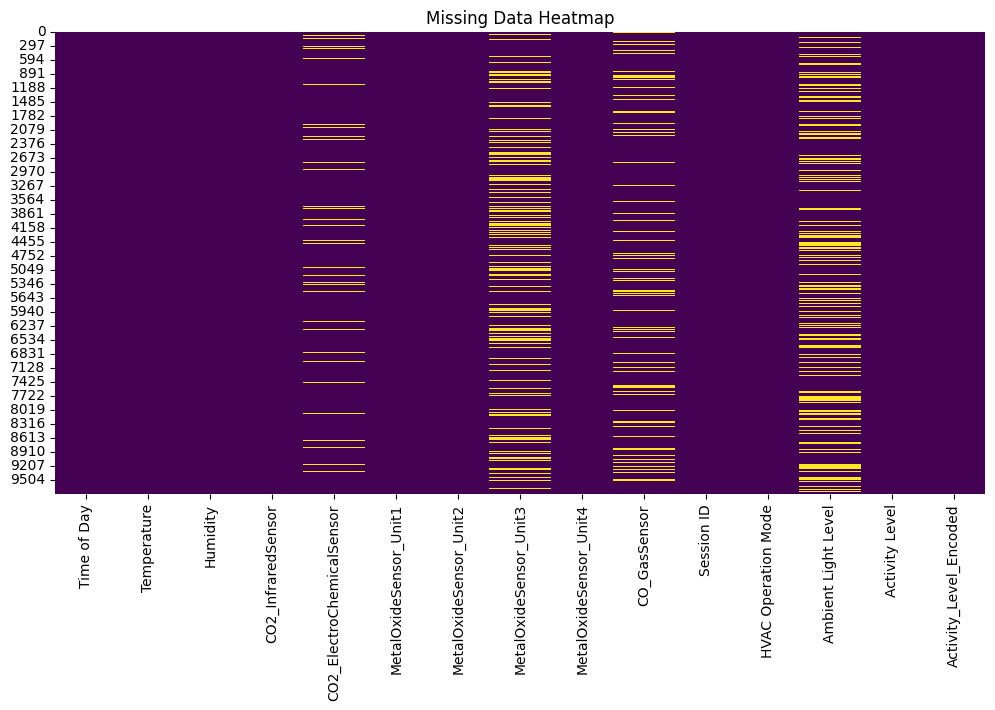


Full-row Duplicates: 0 rows

Sample Duplicates:
 Empty DataFrame
Columns: [Time of Day, Temperature, Humidity, CO2_InfraredSensor, CO2_ElectroChemicalSensor, MetalOxideSensor_Unit1, MetalOxideSensor_Unit2, MetalOxideSensor_Unit3, MetalOxideSensor_Unit4, CO_GasSensor, Session ID, HVAC Operation Mode, Ambient Light Level, Activity Level, Activity_Level_Encoded]
Index: []

Target Distribution:
 Activity Level
Low Activity         5676
Moderate Activity    3054
High Activity        1069
Name: count, dtype: int64


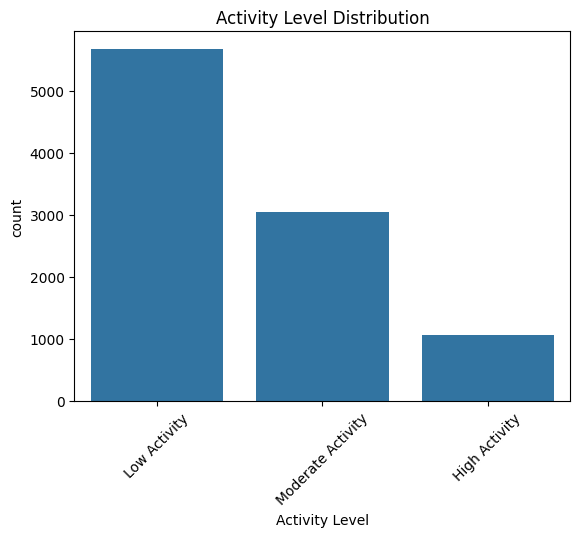


Correlation with Activity Level (Encoded):
 MetalOxideSensor_Unit4       0.241423
MetalOxideSensor_Unit1       0.208963
CO2_ElectroChemicalSensor    0.189879
CO2_InfraredSensor          -0.187575
MetalOxideSensor_Unit2       0.152239
MetalOxideSensor_Unit3       0.143518
Session ID                  -0.032755
Humidity                    -0.016796
Temperature                 -0.005459
dtype: float64


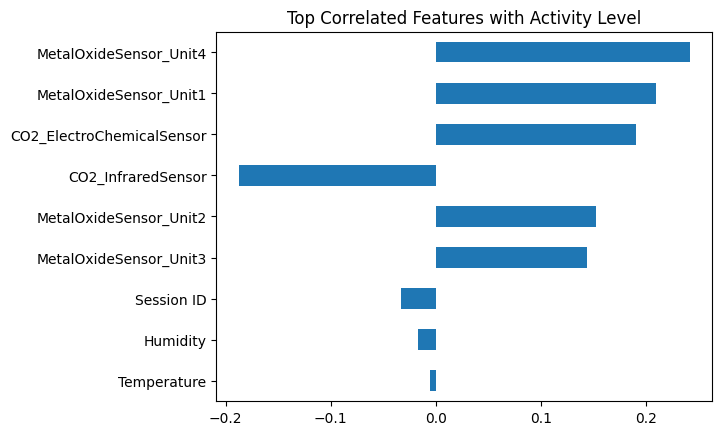


Time of Day Value Counts:
 Time of Day
afternoon    2554
evening      2433
morning      2413
night        2399
Name: count, dtype: int64


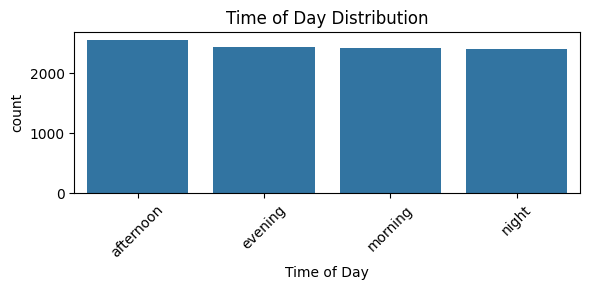


CO_GasSensor Value Counts:
 CO_GasSensor
low               4256
medium            2628
None              1364
extremely low     1091
high               389
extremely high      71
Name: count, dtype: int64


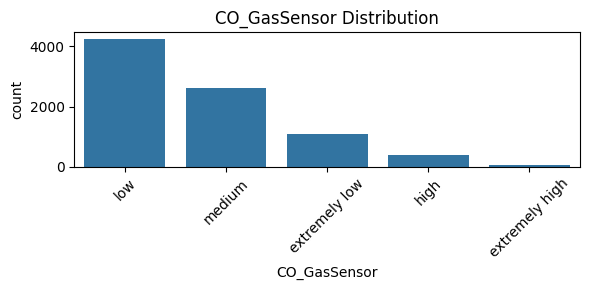


HVAC Operation Mode Value Counts:
 HVAC Operation Mode
Cooling        1672
Maintenance    1664
Heating        1646
Eco            1609
Off            1607
Ventilation    1601
Name: count, dtype: int64


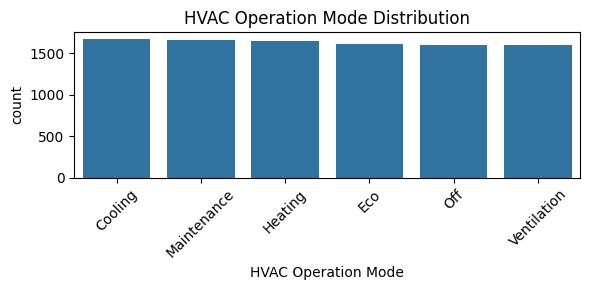


Ambient Light Level Value Counts:
 Ambient Light Level
very_bright    2792
None           2512
bright         2141
moderate       1226
dim             708
very_dim        420
Name: count, dtype: int64


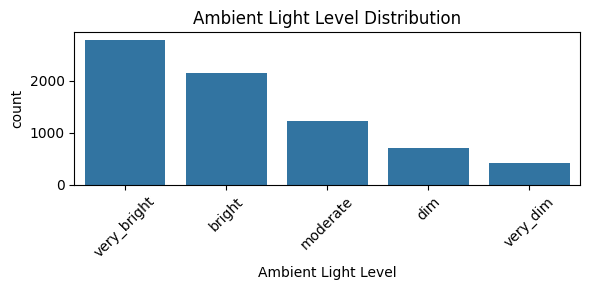

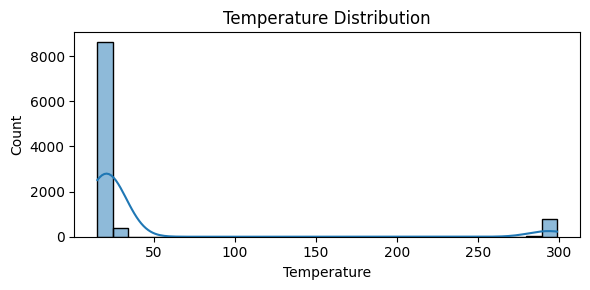

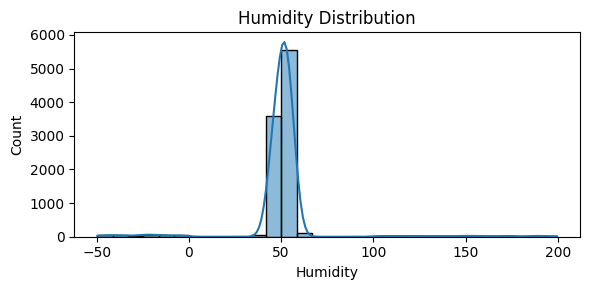

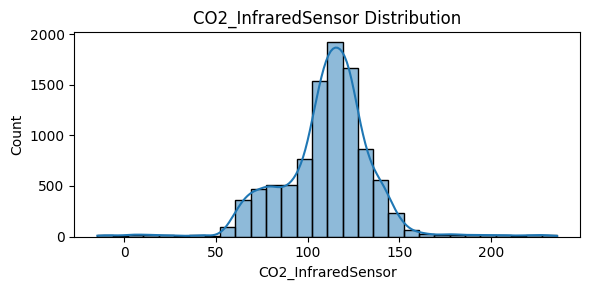

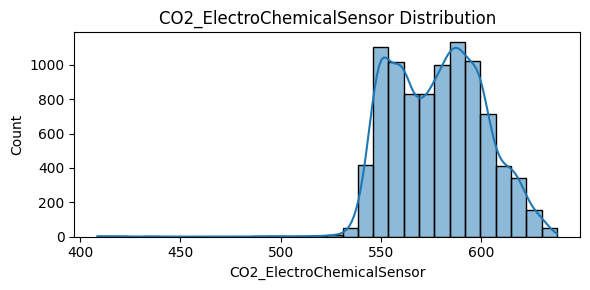

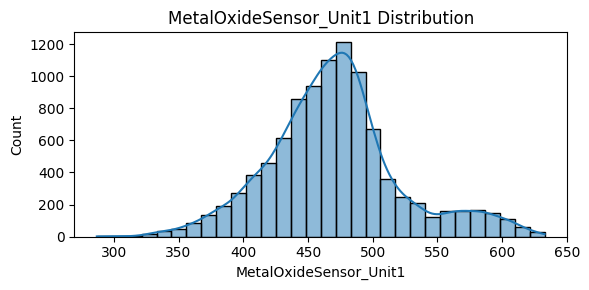

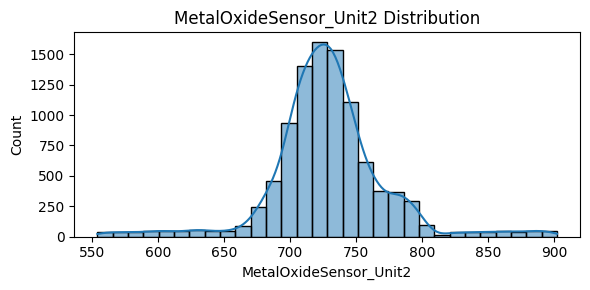

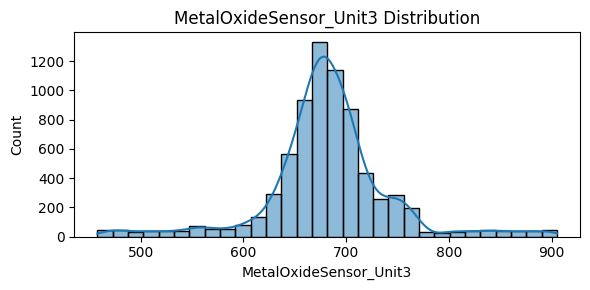

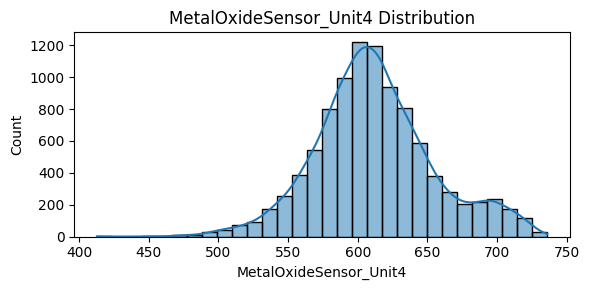

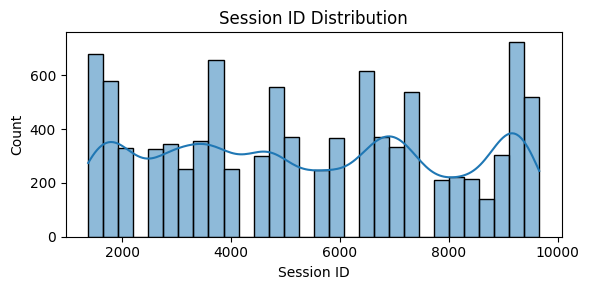


Outlier Count per Feature (Z > 3):
 Temperature               804
Humidity                  420
MetalOxideSensor_Unit2    309
CO2_InfraredSensor        168
MetalOxideSensor_Unit1     23
MetalOxideSensor_Unit4     19
dtype: int64

Session-wise Missingness (Fraction):
        Time of Day  Temperature  Humidity  CO2_InfraredSensor  \
count         38.0         38.0      38.0                38.0   
mean           0.0          0.0       0.0                 0.0   
std            0.0          0.0       0.0                 0.0   
min            0.0          0.0       0.0                 0.0   
25%            0.0          0.0       0.0                 0.0   
50%            0.0          0.0       0.0                 0.0   
75%            0.0          0.0       0.0                 0.0   
max            0.0          0.0       0.0                 0.0   

       CO2_ElectroChemicalSensor  MetalOxideSensor_Unit1  \
count                  38.000000                    38.0   
mean                    0

C:\Users\longs\AppData\Local\Temp\ipykernel_23272\1439260114.py:86: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  session_missing = df.groupby('Session ID').apply(lambda x: x.isnull().mean())


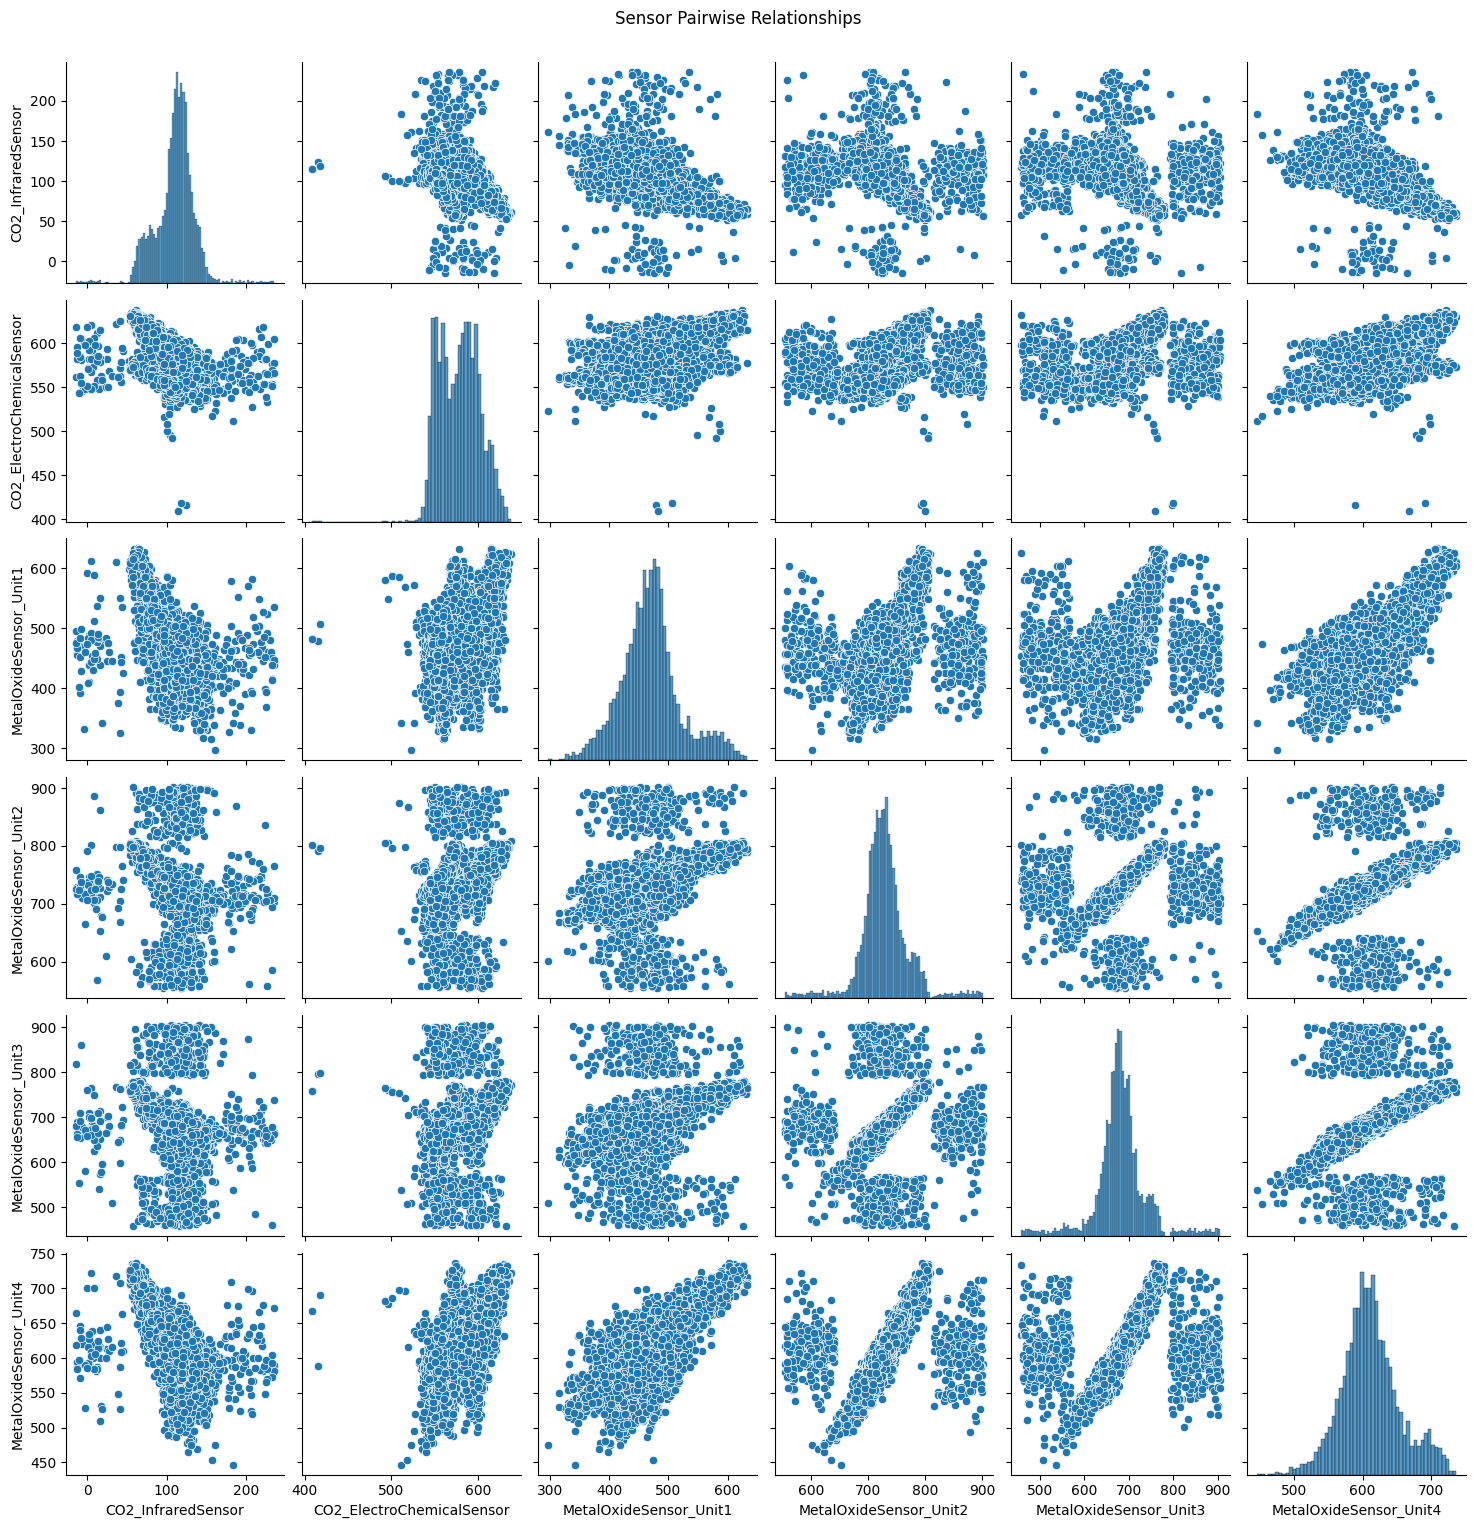

In [129]:
# -------------------------------
# Missing Data Analysis
# -------------------------------
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_counts, 'Missing %': missing_percent})
print("\nMissing Value Summary:\n", missing_df[missing_df['Missing Count'] > 0])

# Visualize missingness
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

# -------------------------------
# Double checking dupes
# -------------------------------
full_dupes = df.duplicated()
print(f"\nFull-row Duplicates: {full_dupes.sum()} rows")

# Optional: View duplicate examples
print("\nSample Duplicates:\n", df[full_dupes].head())

# -------------------------------
# Target Variable Analysis
# -------------------------------
print("\nTarget Distribution:\n", df['Activity Level'].value_counts())
sns.countplot(data=df, x='Activity Level', order=df['Activity Level'].value_counts().index)
plt.title("Activity Level Distribution")
plt.xticks(rotation=45)
plt.show()

# -------------------------------
# Feature-Target Relationships
# -------------------------------
# Encode target for correlation
le = LabelEncoder()
df['Activity_Level_Encoded'] = le.fit_transform(df['Activity Level'])

# Correlation with target (numerical only)
num_cols = df.select_dtypes(include='number').columns.drop('Activity_Level_Encoded')
correlations = df[num_cols].corrwith(df['Activity_Level_Encoded']).sort_values(key=abs, ascending=False)
print("\nCorrelation with Activity Level (Encoded):\n", correlations)

# Visualize top correlated features
correlations.head(10).plot(kind='barh', title='Top Correlated Features with Activity Level')
plt.gca().invert_yaxis()
plt.show()

# -------------------------------
# Categorical Feature Exploration
# -------------------------------
cat_cols = df.select_dtypes(include='object').columns.drop('Activity Level')
for col in cat_cols:
    print(f"\n{col} Value Counts:\n", df[col].value_counts(dropna=False))
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Numerical Feature Distributions
# -------------------------------
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"{col} Distribution")
    plt.tight_layout()
    plt.show()

# -------------------------------
# Outlier Detection (Z-score)
# -------------------------------
from scipy.stats import zscore

z_scores = df[num_cols].apply(zscore)
outlier_flags = (np.abs(z_scores) > 3)
outlier_summary = outlier_flags.sum().sort_values(ascending=False)
print("\nOutlier Count per Feature (Z > 3):\n", outlier_summary[outlier_summary > 0])

# -------------------------------
# Session-wise Missingness
# -------------------------------
session_missing = df.groupby('Session ID').apply(lambda x: x.isnull().mean())
print("\nSession-wise Missingness (Fraction):\n", session_missing.describe())

# -------------------------------
# Cross-Sensor Relationships
# -------------------------------
sns.pairplot(df[['CO2_InfraredSensor', 'CO2_ElectroChemicalSensor', 'MetalOxideSensor_Unit1',
                     'MetalOxideSensor_Unit2', 'MetalOxideSensor_Unit3', 'MetalOxideSensor_Unit4']].dropna())
plt.suptitle("Sensor Pairwise Relationships", y=1.02)
plt.show()

HVAC feature plot shows same issue with Activity Level where needs normalizing so I am going to normalize it right away

In [89]:
hvac_mapping = {
    # cooling
    'cooling_active': 'Cooling',
    'COOLING_ACTIVE': 'Cooling',
    'Cooling_active': 'Cooling',
    'Cooling_Active': 'Cooling',
    # heating
    'heating_active': 'Heating',
    'HEATING_ACTIVE': 'Heating',
    'Heating_Active': 'Heating',
    'Heating_active': 'Heating',
    # maintenance
    'maintenance_mode': 'Maintenance',
    'MAINTENANCE_MODE': 'Maintenance',
    'Maintenance_Mode': 'Maintenance',
    'Maintenance_mode': 'Maintenance',
    # eco
    'eco_mode': 'Eco',
    'ECO_MODE': 'Eco',
    'Eco_mode': 'Eco',
    'Eco_Mode': 'Eco',
    # ventilation
    'ventilation_only': 'Ventilation',
    'VENTILATION_ONLY': 'Ventilation',
    'Ventilation_Only': 'Ventilation',
    'Ventilation_only': 'Ventilation',
    # off
    'off': 'Off',
    'OFF': 'Off',
    'Off': 'Off',
}

df['HVAC Operation Mode'] = (
    df['HVAC Operation Mode']
    .str.strip()
    .map(lambda x: hvac_mapping.get(x, x))  # fallback to original if not in mapping
)

# Check the result
print(df['HVAC Operation Mode'].value_counts())


HVAC Operation Mode
Maintenance    1684
Cooling        1683
Heating        1666
Off            1621
Eco            1618
Ventilation    1608
Name: count, dtype: int64


Now we can run the EDA plots again and check

I need some boxplots to check for outliers in-depth


Outlier Count per Feature (Z > 3):
 Temperature               804
Humidity                  420
MetalOxideSensor_Unit2    309
CO2_InfraredSensor        168
MetalOxideSensor_Unit1     23
MetalOxideSensor_Unit4     19
dtype: int64


C:\Users\longs\AppData\Local\Temp\ipykernel_23272\2208835987.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Activity Level", y=col, showfliers=True, palette="Set2")


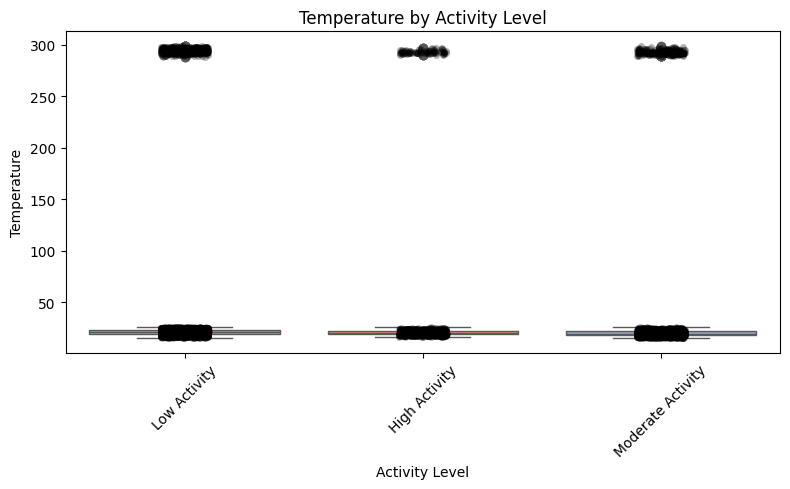

C:\Users\longs\AppData\Local\Temp\ipykernel_23272\2208835987.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Activity Level", y=col, showfliers=True, palette="Set2")


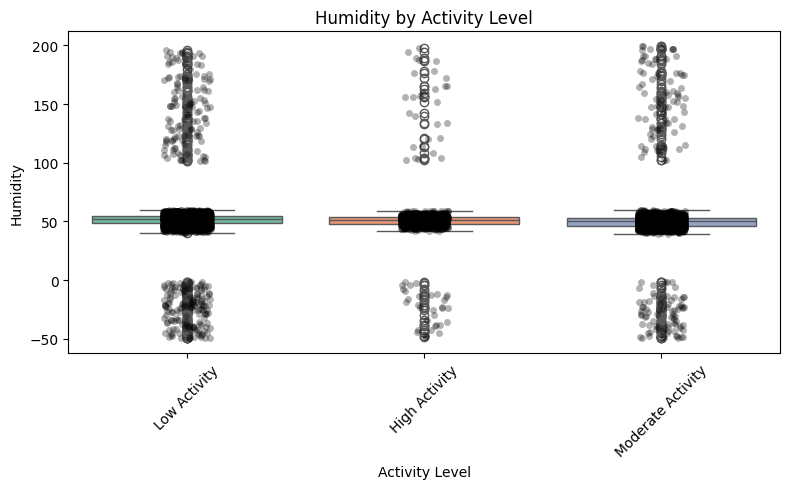

C:\Users\longs\AppData\Local\Temp\ipykernel_23272\2208835987.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Activity Level", y=col, showfliers=True, palette="Set2")


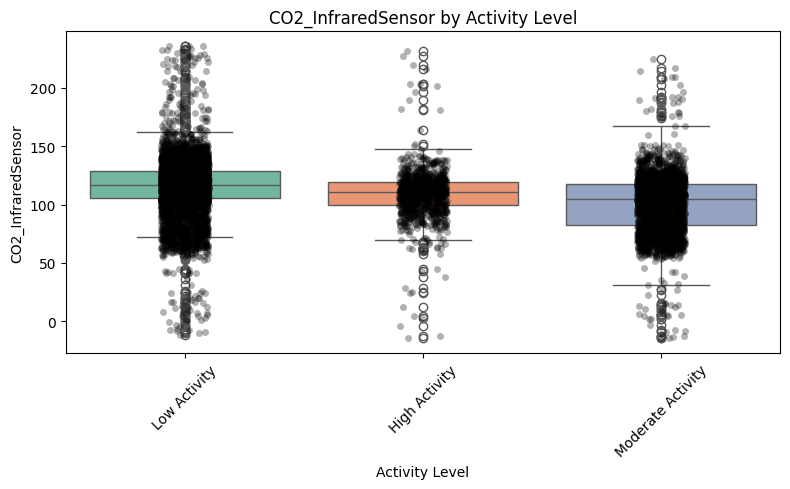

C:\Users\longs\AppData\Local\Temp\ipykernel_23272\2208835987.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Activity Level", y=col, showfliers=True, palette="Set2")


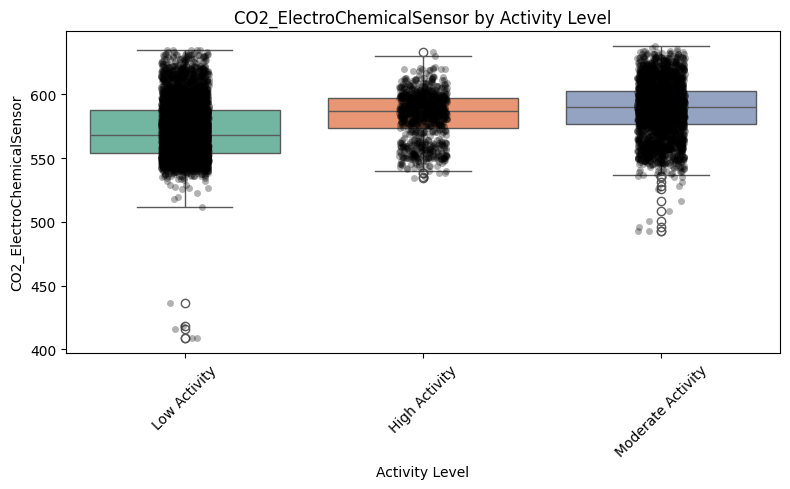

C:\Users\longs\AppData\Local\Temp\ipykernel_23272\2208835987.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Activity Level", y=col, showfliers=True, palette="Set2")


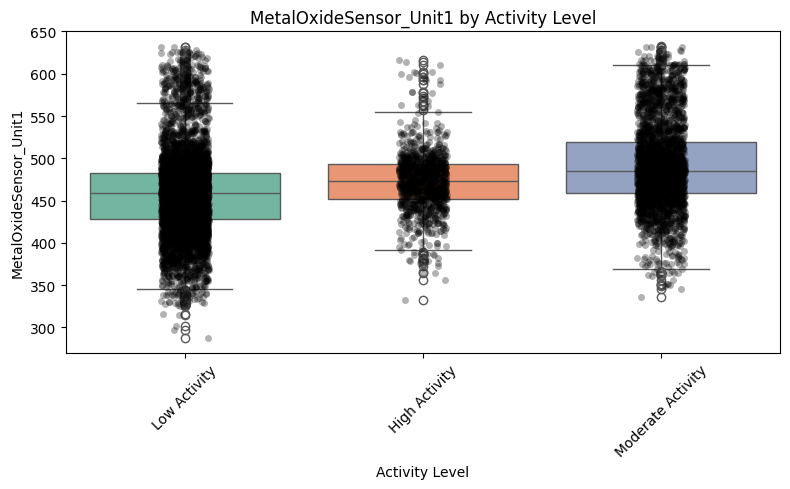

C:\Users\longs\AppData\Local\Temp\ipykernel_23272\2208835987.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Activity Level", y=col, showfliers=True, palette="Set2")


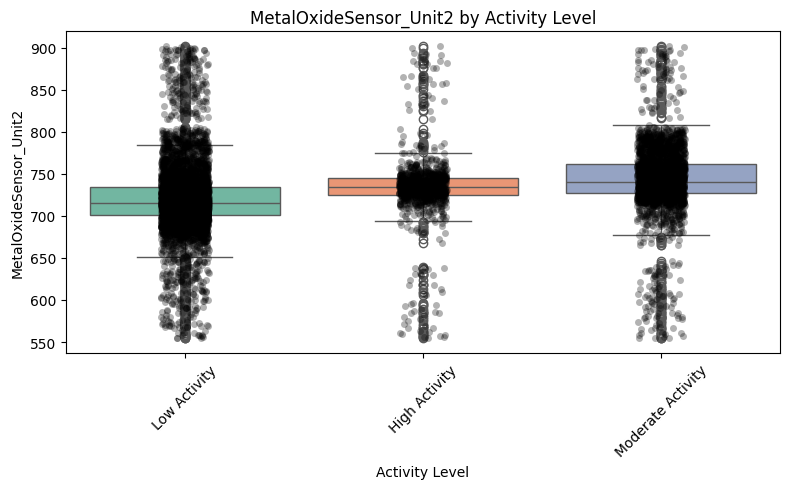

C:\Users\longs\AppData\Local\Temp\ipykernel_23272\2208835987.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Activity Level", y=col, showfliers=True, palette="Set2")


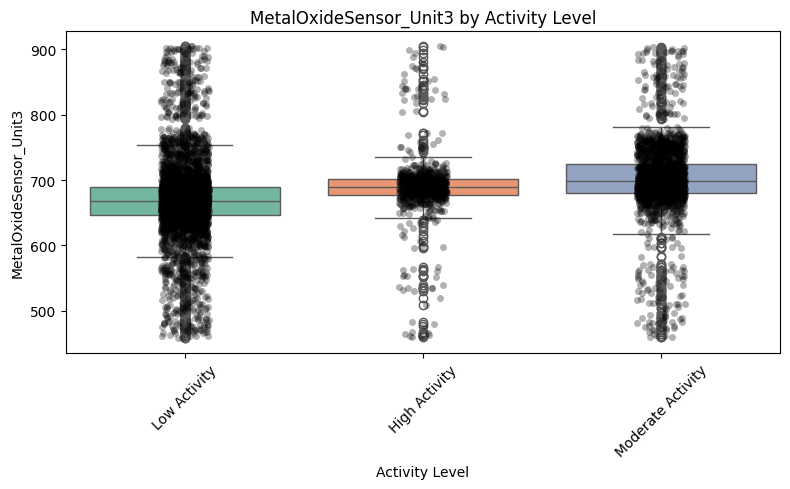

C:\Users\longs\AppData\Local\Temp\ipykernel_23272\2208835987.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Activity Level", y=col, showfliers=True, palette="Set2")


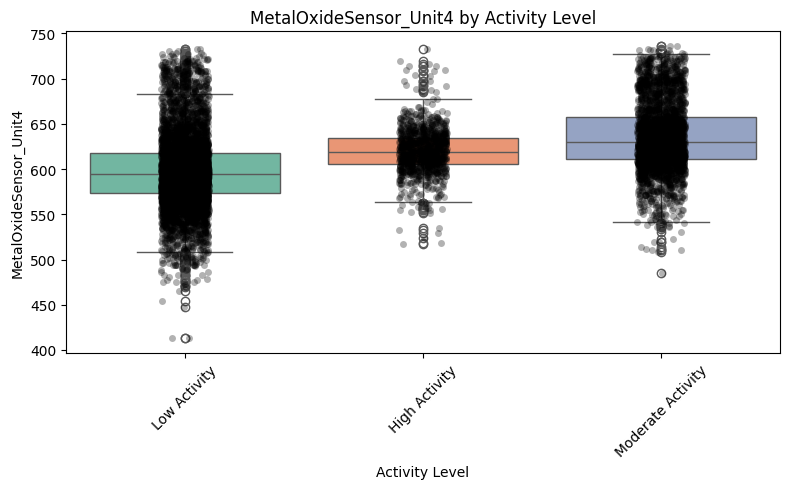

In [123]:
number_cols = [
    "Temperature", "Humidity", "CO2_InfraredSensor", "CO2_ElectroChemicalSensor",
    "MetalOxideSensor_Unit1", "MetalOxideSensor_Unit2", "MetalOxideSensor_Unit3", "MetalOxideSensor_Unit4"
]

z_scores = df[number_cols].apply(zscore)
outlier_flags = (np.abs(z_scores) > 3)
outlier_summary = outlier_flags.sum().sort_values(ascending=False)
print("\nOutlier Count per Feature (Z > 3):\n", outlier_summary[outlier_summary > 0])

# Plot each feature individually
for col in number_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="Activity Level", y=col, showfliers=True, palette="Set2")
    sns.stripplot(data=df, x="Activity Level", y=col, color='black', alpha=0.3, jitter=True)
    plt.title(f"{col} by Activity Level")
    plt.xlabel("Activity Level")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



Temperature boxplot in relation to activity level shows some unrealistc numbers for temperature values at 300+ while the other boxplots have healthier outliers

# Next Steps

# Model Comparison

C:\Users\longs\AppData\Local\Temp\ipykernel_10088\556455877.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=macro_f1, palette="Set2")


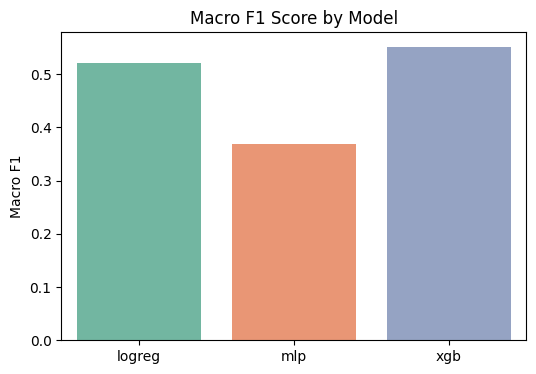

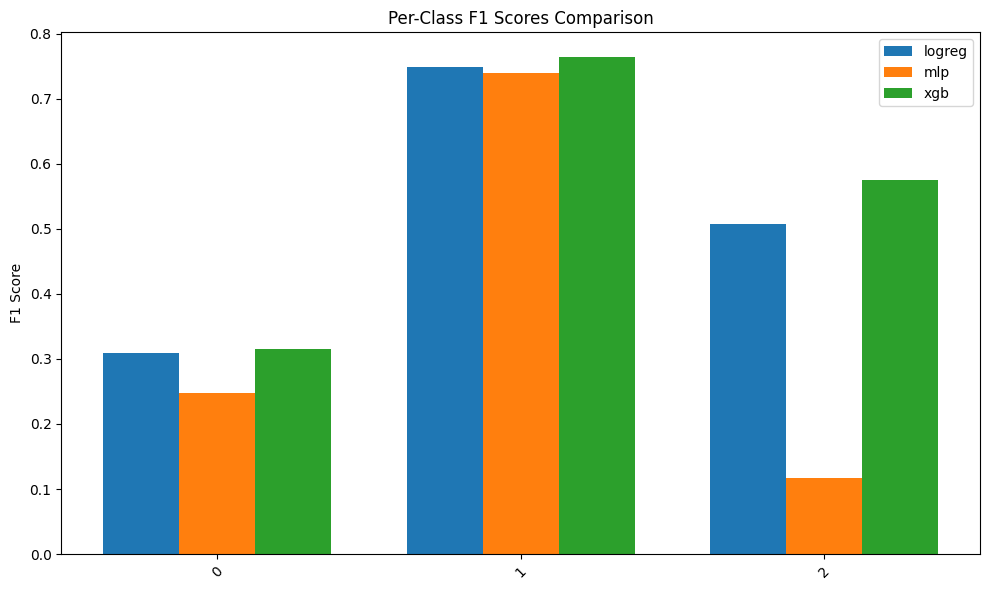

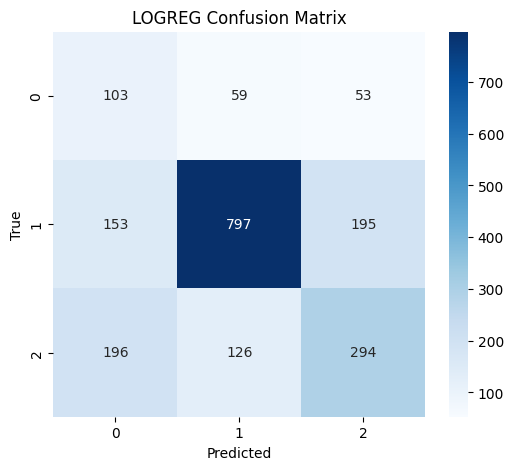

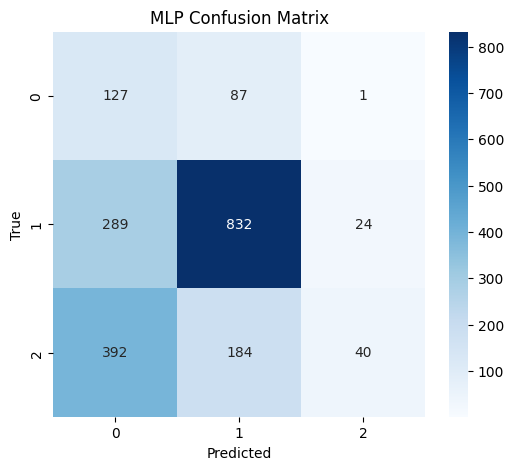

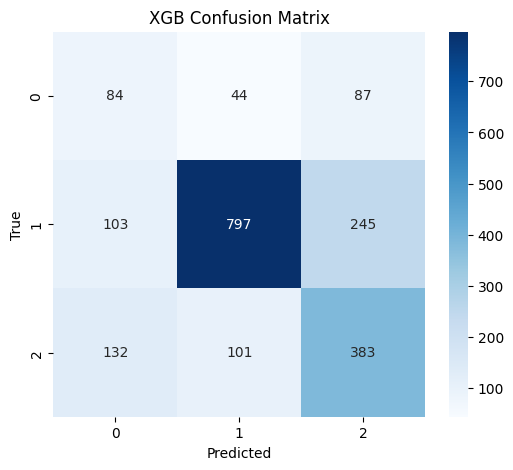


=== Model Comparison Summary ===
 Model  Macro F1        0        1        2
logreg  0.522010 0.308846 0.749412 0.507772
   mlp  0.368659 0.248289 0.740214 0.117474
   xgb  0.551297 0.314607 0.763776 0.575507


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load JSON results
with open("artifacts/model_comparison.json", "r") as f:
    comparison = json.load(f)

models = list(comparison.keys())

# Macro F1 comparison (bar chart)
# -------------------------------
macro_f1 = [comparison[m]["macro_f1"] for m in models]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=macro_f1, palette="Set2")
plt.title("Macro F1 Score by Model")
plt.ylabel("Macro F1")
plt.show()

# Per-class F1 comparison (grouped bar chart)
# -------------------------------
per_class = {m: comparison[m]["per_class_f1"] for m in models}
classes = list(per_class[models[0]].keys())

plt.figure(figsize=(10,6))
bar_width = 0.25
for i, m in enumerate(models):
    scores = [per_class[m][c] for c in classes]
    plt.bar([x+i*bar_width for x in range(len(classes))], scores, 
            width=bar_width, label=m)

plt.xticks([x+bar_width for x in range(len(classes))], classes, rotation=45)
plt.title("Per-Class F1 Scores Comparison")
plt.ylabel("F1 Score")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrices (heatmaps)
# -------------------------------
for m in models:
    cm = comparison[m]["confusion_matrix"]
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{m.upper()} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Summary table (macro + per-class F1)
# -------------------------------
summary_data = []
for m in models:
    row = {"Model": m, "Macro F1": comparison[m]["macro_f1"]}
    row.update(comparison[m]["per_class_f1"])
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("\n=== Model Comparison Summary ===")
print(summary_df.to_string(index=False))
